# S16 T01: Pipelines, grid search i text mining


Observacions:
1.   Notebook desenvolupat utilitzant Google Colab
2.   Repeteixo en aquest notebook el preprocessament del dataset que ja haviem fet en tasques anteriors per tal que el notebook sigui "autocontingut"



In [1]:
# Upgrade Sklearn (in Colab) to latest version 0.24.2
!pip install scikit-learn --upgrade  &> /dev/null

In [2]:
!pip install --upgrade nltk &> /dev/null

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import set_config
from tqdm.notebook import tqdm
from functools import partial
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Notebook configuration

# Plots
%matplotlib inline

# Pandas
pd.set_option("display.max_columns", None) # Display all columns of DataFrame

# Pipelines
set_config(display='diagram')  # Display pipelines graphically

# Progress bars
tqdm = partial(tqdm, position=0, leave=True)

# Constants
RS = 42  # Random_state constant value


## Nivell 1 - Exercici 1
Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

- Fem servir el **breast cancer wisconsin dataset** de sklearn.

In [5]:
data = load_breast_cancer(as_frame=True)

In [6]:
target_names = data.target_names
target_names

array(['malignant', 'benign'], dtype='<U9')

In [7]:
df = data.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


- Separem train/test

In [8]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.iloc[:,:-1],
                                                                df['target'],
                                                                test_size=0.3,
                                                                stratify=df[['target']],
                                                                random_state=RS,
                                                                shuffle=True)

total_size = df.shape[0]
train_size = df_X_train.shape[0]
test_size = df_X_test.shape[0]

print(f'Total size of the dataset: {total_size} samples')
print(f'Check of training set size: {train_size} samples ({100*train_size/total_size:.2f}%)')
print(f'Check of test set size: {test_size} samples ({100*test_size/total_size:.2f}%)')

Total size of the dataset: 569 samples
Check of training set size: 398 samples (69.95%)
Check of test set size: 171 samples (30.05%)


- **Base model:** Per poder comparar les millores amb l'ajust de hiperparàmetres, creem un model RandomForest amb els paràmetres per defecte de sklearn

In [9]:
# Base model

scaler_base = StandardScaler()
rf_base = RandomForestClassifier(random_state=RS, n_jobs=-1)

pipe_base = Pipeline([('scaler', scaler_base),
                     ('classifier', rf_base)
                    ]);

pipe_base.fit(df_X_train, df_y_train);

In [17]:
print('Classification report (Base model):\n')
print(classification_report(df_y_test, pipe_base.predict(df_X_test), digits=4, target_names=target_names))

Classification report (Base model):

              precision    recall  f1-score   support

   malignant     0.9206    0.9062    0.9134        64
      benign     0.9444    0.9533    0.9488       107

    accuracy                         0.9357       171
   macro avg     0.9325    0.9298    0.9311       171
weighted avg     0.9355    0.9357    0.9356       171



- **Random Search**: primer fem una exploració ràpida de l'espai de hiperparàmetres fent un random search i a partir del resultat obtingut, farem un GridSearch per trobar els valors òptims.


In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2100, num = 11)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 140, num = 14)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Criterion
criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

pprint(random_grid, width=100)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, None],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100]}


In [19]:
scaler_random = StandardScaler();
rf_random = RandomForestClassifier(random_state=RS, n_jobs=-1)

rf_random_search = RandomizedSearchCV(estimator = rf_random, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=RS, 
                               n_jobs = -1,
                               refit=True);

pipe_random_search = Pipeline([('scaler', scaler_random),
                     ('classifier', rf_random_search)
                    ]);

pipe_random_search.fit(df_X_train, df_y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [20]:
print('Classification report (Randomized Search best parameters):\n')
print(classification_report(df_y_test, pipe_random_search.predict(df_X_test), digits=4, target_names=target_names))

Classification report (Randomized Search best parameters):

              precision    recall  f1-score   support

   malignant     0.9355    0.9062    0.9206        64
      benign     0.9450    0.9626    0.9537       107

    accuracy                         0.9415       171
   macro avg     0.9402    0.9344    0.9372       171
weighted avg     0.9414    0.9415    0.9413       171



Veiem com hem millorat les prediccions per exemple fixant-nos en el f1-score que ha augmentat per a les dues classes (benign i malignant). 

Ara podem intentar fer un ajust més precis utilitzant GridSearch a partir dels paràmetres que hem trobat amb el Randomized Search.

In [21]:
print("Best Parameters after Randomized Search:\n")

pipe_random_search['classifier'].best_params_

Best Parameters after Randomized Search:



{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1500}

- **Grid Search**: fem una recerca dels hiperparàmetres al voltant dels valors que hem obtingut amb el Randomized Search.

In [ ]:
param_grid = {
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_depth': [10, 20, 30, 40],
    'max_features': ['log2'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1450, 1500, 1650]
}

scaler_grid = StandardScaler();
rf_grid = RandomForestClassifier(random_state=RS, n_jobs=-1);

rf_grid_search = GridSearchCV(estimator = rf_grid, 
                       param_grid = param_grid,
                       cv = 3,
                       verbose=2,
                       n_jobs = -1,
                       refit=True);

pipe_grid_search = Pipeline([('scaler', scaler_grid),
                             ('classifier', rf_grid_search)
                            ]);

pipe_grid_search.fit(df_X_train, df_y_train)

In [31]:
print('Classification report (GridSearchCV best parameters):')
print(classification_report(df_y_test, pipe_grid_search.predict(df_X_test), digits=4, target_names=target_names))

Classification report (GridSearchCV best parameters):
              precision    recall  f1-score   support

   malignant     0.9508    0.9062    0.9280        64
      benign     0.9455    0.9720    0.9585       107

    accuracy                         0.9474       171
   macro avg     0.9481    0.9391    0.9433       171
weighted avg     0.9475    0.9474    0.9471       171



Veiem com hem millorat una mica més els scores del model predictiu, sobretot  la precisió de la classe "malignant".

In [33]:
print("Best Parameters after Grid Search:\n")

pipe_grid_search['classifier'].best_params_

Best Parameters after Grid Search:



{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1450}

## Nivell 1 - Exercici 2
Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules.

Com a text he agafat un article d'opinió de TheGuardian titulat **"Who's to blame for the Afghanistan chaos?"** que tracta sobre la retirada de les tropes americanes d'Afghanistan:

https://www.theguardian.com/commentisfree/2021/aug/25/blame-afghanistan-war-media-intervention

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
# Downloads 
nltk.download('punkt')  # Sentence tokenizer for english language
nltk.download('stopwords') # Stopwords for english language
nltk.download('vader_lexicon') # Sentiment analysis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Download the text from my github.
# It's an article from TheGuardian newspaper

!wget "https://raw.githubusercontent.com/itacademy-rogergallart/machine-learning-avancat/main/theguardian_article.txt"

with open('theguardian_article.txt', 'r') as file:
  article = file.read().replace('\n',' ')

--2021-10-01 19:16:43--  https://raw.githubusercontent.com/itacademy-rogergallart/machine-learning-avancat/main/theguardian_article.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6801 (6.6K) [text/plain]
Saving to: ‘theguardian_article.txt.2’

theguardian_article 100%[===================>]   6.64K  --.-KB/s    in 0s      

2021-10-01 19:16:44 (76.2 MB/s) - ‘theguardian_article.txt.2’ saved [6801/6801]



In [ ]:
# Tokenization
tokenized_word_raw = word_tokenize(article)
print("Word tokenization:")
print(tokenized_word_raw)

# Remove punctuation
tokenized_word= [word for word in tokenized_word_raw if word.isalnum()]
print("\nWord tokenization without punctuation:")
print(tokenized_word)

Word tokenization:
['Who', '’', 's', 'to', 'blame', 'for', 'the', 'Afghanistan', 'chaos', '?', 'Remember', 'the', 'war', '’', 's', 'cheerleaders.Everyone', 'is', 'to', 'blame', 'for', 'the', 'catastrophe', 'in', 'Afghanistan', ',', 'except', 'the', 'people', 'who', 'started', 'it', '.', 'Yes', ',', 'Joe', 'Biden', 'screwed', 'up', 'by', 'rushing', 'out', 'so', 'chaotically', '.', 'Yes', ',', 'Boris', 'Johnson', 'and', 'Dominic', 'Raab', 'failed', 'to', 'make', 'adequate', 'and', 'timely', 'provisions', 'for', 'the', 'evacuation', 'of', 'vulnerable', 'people', '.', 'But', 'there', 'is', 'a', 'frantic', 'determination', 'in', 'the', 'media', 'to', 'ensure', 'that', 'none', 'of', 'the', 'blame', 'is', 'attached', 'to', 'those', 'who', 'began', 'this', 'open-ended', 'war', 'without', 'realistic', 'aims', 'or', 'an', 'exit', 'plan', ',', 'then', 'waged', 'it', 'with', 'little', 'concern', 'for', 'the', 'lives', 'and', 'rights', 'of', 'the', 'Afghan', 'people', ':', 'the', 'then', 'US', 'pre

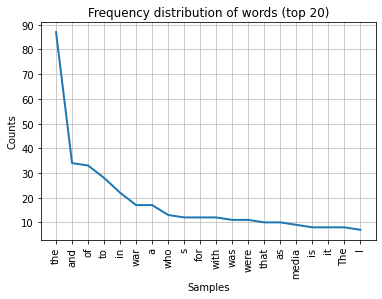

  the   and    of    to    in   war     a   who     s   for  with   was  were  that    as media    is    it   The     I 
   87    34    33    28    22    17    17    13    12    12    12    11    11    10    10     9     8     8     8     7 


In [ ]:
# Frequency distribution
fdist = FreqDist(tokenized_word)

fdist.plot(20, title="Frequency distribution of words (top 20)", cumulative=False)
plt.show()

fdist.tabulate(20)


## Nivell 2 - Exercici 1
Treu les stopwords i realitza stemming al teu conjunt de dades.

In [ ]:
# List of stopwords in english
stop_words = set(stopwords.words("english"))
print(stop_words)

{'is', 'were', 'the', 'by', 've', "isn't", 'at', 'they', 'y', "you've", 'won', 'against', 'be', 'about', 't', 'been', 'can', 'it', 'had', 'because', 'some', 'those', 'am', 'o', 'whom', 'through', 'wasn', 'under', 're', 'll', 'shouldn', 'i', 'theirs', 'what', 'how', 'own', 'in', 'ma', 'each', 'doesn', 'itself', 'only', 'there', 'an', 'me', 'of', 'off', 'shan', 'hasn', 'did', 'during', 'here', 'haven', 'which', 'them', 'couldn', "needn't", 'her', 'themselves', 'yourself', 'isn', 'that', 'but', 'from', 'once', 'will', 'his', "mightn't", "doesn't", 'was', 'hers', 'up', 'then', 'does', 'm', 'than', 'just', 'further', 'few', "should've", 'too', 'he', "that'll", 'until', 'my', 'your', "haven't", 'where', 'yourselves', "wasn't", 'mustn', 'with', 'you', 'while', 'our', 'as', "won't", 'are', "didn't", 'weren', 'this', 'a', 'do', 'both', 'aren', "hadn't", "mustn't", 'him', "hasn't", "it's", "she's", 'more', 'ourselves', 'yours', 'its', "shouldn't", 'no', "you'll", 'for', 'why', "shan't", "you'd",

In [ ]:
# Filter (remove) the stopwords from the tokenized words list

filtered_words = [w for w in tokenized_word if w.lower() not in stop_words]
print("Filtered Words:\n",filtered_words)


Filtered Words:
 ['blame', 'Afghanistan', 'chaos', 'Remember', 'war', 'cheerleaders', 'Everyone', 'blame', 'catastrophe', 'Afghanistan', 'except', 'people', 'started', 'Yes', 'Joe', 'Biden', 'screwed', 'rushing', 'chaotically', 'Yes', 'Boris', 'Johnson', 'Dominic', 'Raab', 'failed', 'make', 'adequate', 'timely', 'provisions', 'evacuation', 'vulnerable', 'people', 'frantic', 'determination', 'media', 'ensure', 'none', 'blame', 'attached', 'began', 'war', 'without', 'realistic', 'aims', 'exit', 'plan', 'waged', 'little', 'concern', 'lives', 'rights', 'Afghan', 'people', 'US', 'president', 'George', 'W', 'Bush', 'British', 'prime', 'minister', 'Tony', 'Blair', 'entourages', 'Indeed', 'Blair', 'transfer', 'blame', 'Biden', 'last', 'weekend', 'news', 'opposed', 'disastrous', 'war', '20', 'years', 'ago', 'remain', 'cancelled', 'across', 'media', 'acknowledge', 'mistakes', 'men', 'prosecuted', 'war', 'would', 'expose', 'media', 'role', 'facilitating', 'fair', 'reckoning', 'went', 'wrong', 'Af

In [ ]:
# Stemming
ps = PorterStemmer()
stemmed_words = [ps.stem(w) for w in filtered_words]

print("Stemmed Sentence:",stemmed_words)

Stemmed Sentence: ['blame', 'afghanistan', 'chao', 'rememb', 'war', 'cheerlead', 'everyon', 'blame', 'catastroph', 'afghanistan', 'except', 'peopl', 'start', 'ye', 'joe', 'biden', 'screw', 'rush', 'chaotic', 'ye', 'bori', 'johnson', 'domin', 'raab', 'fail', 'make', 'adequ', 'time', 'provis', 'evacu', 'vulner', 'peopl', 'frantic', 'determin', 'media', 'ensur', 'none', 'blame', 'attach', 'began', 'war', 'without', 'realist', 'aim', 'exit', 'plan', 'wage', 'littl', 'concern', 'live', 'right', 'afghan', 'peopl', 'us', 'presid', 'georg', 'w', 'bush', 'british', 'prime', 'minist', 'toni', 'blair', 'entourag', 'inde', 'blair', 'transfer', 'blame', 'biden', 'last', 'weekend', 'news', 'oppos', 'disastr', 'war', '20', 'year', 'ago', 'remain', 'cancel', 'across', 'media', 'acknowledg', 'mistak', 'men', 'prosecut', 'war', 'would', 'expos', 'media', 'role', 'facilit', 'fair', 'reckon', 'went', 'wrong', 'afghanistan', 'iraq', 'nation', 'swept', 'war', 'terror', 'includ', 'disastr', 'perform', 'media

## Nivell 3 - Exercici 1
Realitza sentiment analysis al teu conjunt de dades.

### Utilitzant NLTK/Vader

In [ ]:
# Sentiment intensity analysis
sia = SentimentIntensityAnalyzer()

# Compound score can range -1 (negative) to 1 (positive)
print(f"Overall article compound score: {sia.polarity_scores(article)['compound']}")


Overall article compound score: -0.9995


Veiem que el sentiment és negatiu, com era d'esperar ja que es tracta d'un article periodistic critic sobre un event dramàtic.

Si analitzem el sentiment de cada frase:

In [ ]:
df = pd.DataFrame(sent_tokenize(article), columns=['Sentence'])
df['Compound_score'] = df['Sentence'].apply(lambda sentence: sia.polarity_scores(sentence)['compound'])

df.head()

Overall article compound score: -0.9995


,Sentence,Compound_score
0,Who’s to blame for the Afghanistan chaos?,-0.7269
1,Remember the war’s cheerleaders.,0.2960
2,Everyone is to blame for the catastrophe in Af...,-0.7783
3,"Yes, Joe Biden screwed up by rushing out so ch...",-0.1280
4,"Yes, Boris Johnson and Dominic Raab failed to ...",-0.1531


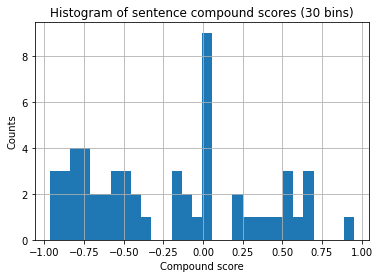

In [ ]:
N_BINS = 30
df.Compound_score.hist(bins=N_BINS);
plt.title(f'Histogram of sentence compound scores ({N_BINS} bins)');
plt.xlabel('Compound score');
plt.ylabel('Counts');

Veiem com la majoria de frases tenen un sentiment negatiu o neutre.